## Домашняя работа #3.

Домашнее задание сдаётся в виде ссылки (с доступом комментатор или редактор) на Colab в опросе:
https://forms.gle/zemRsbegG9fQRVw76

Отправлять ссылку через форму нужно только один раз. Исправления вносятся в тот же ноутбук до хард-дедлайна и помечаются комментариями в коде и комментариями к соотвествующим ячейкам.

Материалы к домашке доступны по ссылке:
https://drive.google.com/drive/folders/1dNoAOMcrRyuf_3vS1LTPpdyrqYxgvPOy?usp=sharing



Большая домашка с увеличенным баллом и временем до дедлайна.
* Морфлогия.
* Фильтры габора.
* Цветовые гистрограммы.
* Гистограммы градиентов.


**Soft deadline: 25.03.2022 03:00:00 +0003 GMT**

**Hard deadline: 01.04.2022 03:00:00 +0003 GMT**

In [1]:
# ПРИМОНТИРУЙТЕ ДИСК К НОУТБУКУ
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
from pathlib import Path
# ИЗМЕНИТЕ ЭТОТ ПУТЬ НА ТОТ, КУДА ВЫ ПОЛОЖИЛИ МАТЕРИАЛЫ КУРСА
sources_path = Path("./data")
sources_path

PosixPath('data')

In [3]:
import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')

def pyplot(func):
    def make_pyplot_context(*args, **kwargs):
        plt.figure(figsize=kwargs.get('size', (10, 5)))
        ax = plt.axes([0,0,1,1], frameon=False)
        ax.set_axis_off()
        return func(*args, **kwargs)
    return make_pyplot_context

@pyplot
def show_bgr(img, size=(10, 5)):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

@pyplot
def show_gray(img, size=(10, 5)):
    plt.imshow(img, cmap='gray')

def mse(img1, img2):
    return ((img1.astype(int) - img2.astype(int)) ** 2).mean()

# МОРФОЛОГИЯ

**1. (5 баллов)** Выделите в изображении $table.jpg$ границы таблицы с использованием морфологических операций. Результатом обработки должно бытьn изображение, в котором удален весь текст и оставлены только границы таблицы.

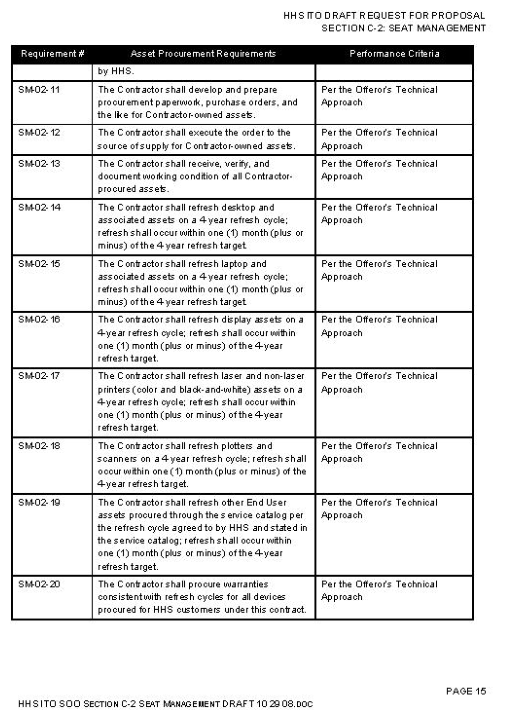

In [4]:
table = cv2.imread(str(sources_path / "table.jpg"), 0)
show_gray(table, size=(5, 10))

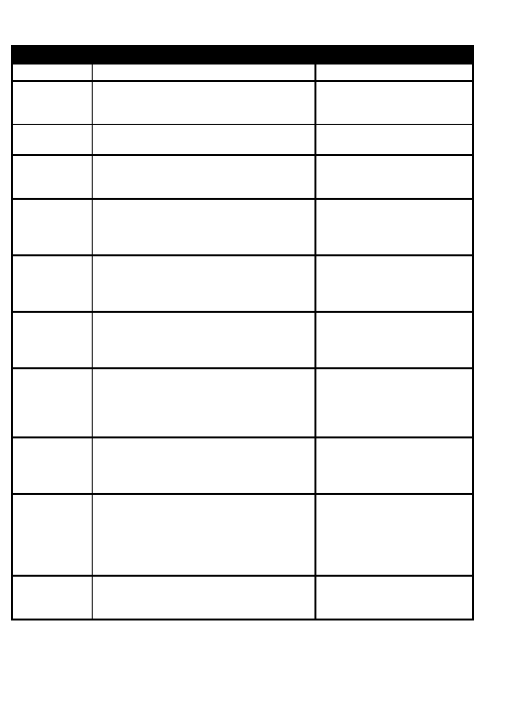

In [5]:
# находим вертикальные черные линии
tmp_v = cv2.morphologyEx(cv2.bitwise_not(table), cv2.MORPH_OPEN,
                         np.ones((9, 1), np.uint8))
# горизонтальные линии
tmp_h = cv2.morphologyEx(cv2.bitwise_not(table), cv2.MORPH_OPEN,
                         np.ones((1, 9), np.uint8))
# объединяем эти линии
new_table = cv2.bitwise_or(tmp_v, tmp_h)
# удаляем текст в шапке таблицы
new_table = cv2.morphologyEx(new_table, cv2.MORPH_CLOSE, np.ones((9, 3), np.uint8),
                             borderType=cv2.BORDER_CONSTANT, borderValue=0)
# удаляем шум, возникший из-за изначальной jpg-компрессии
_, new_table = cv2.threshold(new_table, 128, 255, cv2.THRESH_BINARY_INV)
show_gray(new_table, size=(5, 10))

**2. (5 баллов)** Для изображения $circles.jpg$ реализуйте морфологический алгоритм для построения трех изображений, которые бы содержали соответственно:

* только частицы, касающиеся краев изображения, 

* только группы перекрывающихся частиц,

* только одиночные круглые частицы.

Посчитайте число частиц и групп на каждом изображении. Раскрасьте отдельные компоненты с помощью функции. 

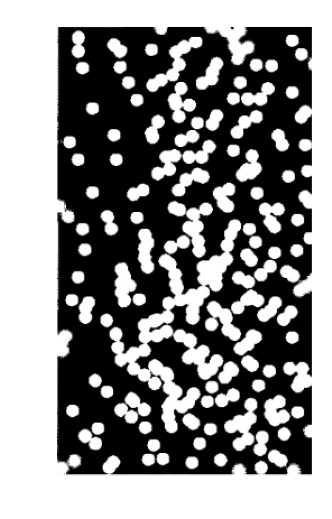

In [6]:
circles = cv2.imread(str(sources_path / "circles.png"), 0)
show_gray(circles)

Не очень понятно, как именно нужно обходиться с белым фоном изображения, из-за него все граничные частицы принадлежать к одной компоненте связности.

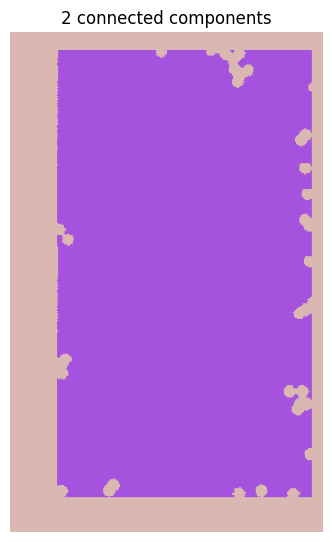

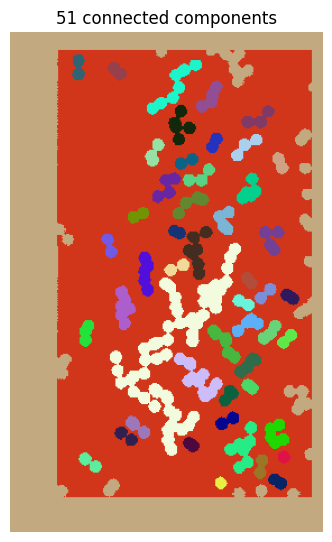

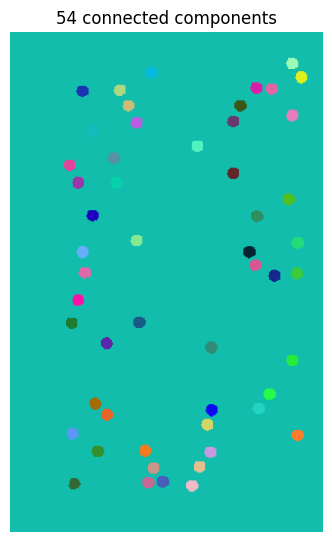

In [7]:
def connected_component(img, i, j):
    """
    Найти компоненту связности пикселя `i, j` в бинарном изображении `img`.
    """
    assert img[i, j] == 1
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    X = np.zeros_like(img)
    X[i, j] = 1
    prev_sum = 1
    while True:
        X_new = cv2.dilate(X, kernel,
                           borderType=cv2.BORDER_CONSTANT,
                           borderValue=0)
        X = cv2.bitwise_and(X_new, img)
        cur_sum = np.sum(X)
        if cur_sum == prev_sum:
            break
        prev_sum = cur_sum
    return X

def is_on_border(mask):
    inds_y, inds_x = np.where(mask > 0)
    return (0 in inds_y or 0 in inds_x
            or mask.shape[0] - 1 in inds_y
            or mask.shape[1] - 1 in inds_x)

def is_single(mask, max_hw=10):
    inds_y, inds_x = np.where(mask > 0)
    h = max(inds_y) - min(inds_y)
    w = max(inds_x) - min(inds_x)
    return max(h, w) <= max_hw
    
def color_components(img):
    assert img.ndim == 2
    out = np.zeros((*img.shape, 3), dtype='uint8')
    count, components = cv2.connectedComponents(img)
    for i in range(count):
        out[components==i] = [np.random.randint(0, 255) for _ in range (3)]
    return count, out
    
_, img = cv2.threshold(circles, 200, 1, cv2.THRESH_BINARY)
found = np.zeros(img.shape, dtype='bool')
img_border = np.zeros_like(img)
img_connected = np.zeros_like(img)
img_single = np.zeros_like(img)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i, j] > 0 and not found[i, j]:
            # находим компоненту связности этого пикселя
            X = connected_component(img, i, j)
            found[X > 0] = True

            # добавляем её в соответствующее изображение
            if is_on_border(X):
                img_border[X > 0] = 1
            if is_single(X, 10):
                img_single[X > 0] = 1
            else:
                img_connected[X > 0] = 1

for img in (img_border, img_connected, img_single):
    cnt, colored = color_components(img)
    show_bgr(colored)
    plt.title(f'{cnt} connected components')

**3. (5 баллов)** **Watershed**

* Возьмите изображения: *coins_1.jpg*, *coins_noize_1.jpg*
* Примените к ним алгоритм водораздела, чтобы посчитать монетки
* отсоритруйте монетки по размеру и у каждой моентки в центре впишите порядковое число

В сниппете кода содержится подсказка о том, какие функции стоит поприменять. 

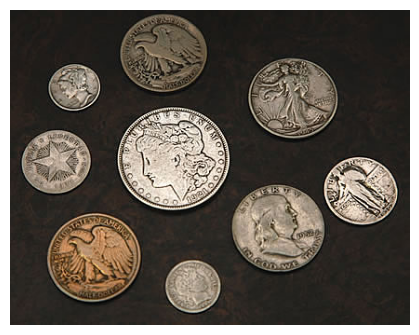

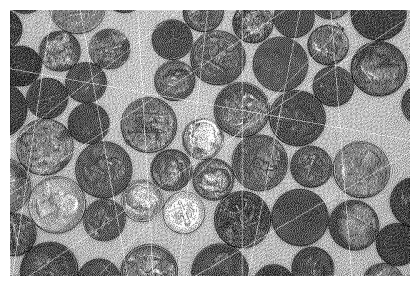

In [12]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import scipy
from scipy.ndimage import distance_transform_edt
from scipy.ndimage import label
from cv2 import pyrMeanShiftFiltering
coins_1 = cv2.imread(str(sources_path / "coins_1.jpg"))
show_bgr(coins_1, size=(4, 5))
coins_2 = cv2.imread(str(sources_path / "coins_noize_2.jpg"))
show_bgr(coins_2, size=(4, 5))

In [261]:
image = pyrMeanShiftFiltering(coins_1, 10, 10)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, image = cv2.threshold(image, 50, 1, cv2.THRESH_BINARY)

distance = distance_transform_edt(image)
coords = peak_local_max(distance, labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = label(mask)
labels = watershed(-distance, markers)
labels.max()

1409

# Фильтры габора

**4. (15 баллов)**  

Реализуйте функцию, которая построит банк фильтров Габора по входящим аргументам n, m. 
* n – число различных частот в дипазоне (0; max_freq]
* m - число различных напралений в диапазоне [0; Pi)

Продемонструйте, что предложенные фильтры более-менее плотно заполняют частотное просранство. Для этого переведите все фильтры в частотное пространство и отобразите все их одновременно на одной картинке. 

Реализуйте интерактивное demo в котром будут два слайдера, один отвечает за разные разные частоы, другой за разные направления. Выведите 3 изображения:
* Вид фильтра в пространстве изображений
* Вид Фильтра в частотном пространстве
* Результат применения фильтра к $lena.jpg$

# Цветовые гистрограммы.

**5. (15 баллов)**

Надо реализовать функцию, которая принимет на вход:

* список дескрипторов (**id**, и сам дескриптор) 
* количество максимально похожих для вывода **n**
* функцию сранения дескрипторов

и отдает **n** пар **id** максимально похожих изображений.

Посмотрите на изображения в папке *Corel*. Посчитайте гистограммы изображений. Выведите на экран 20 пар изображений с максимально похожими гистограммами, которые получаются для лучшей комбинации. В этом задании надо попробовать:
* различные цветовые пространства (RGB, HSV, CIELab)
* различные способы разбиения на бины (разное количество для каждой характеристики, joint_vs_marginal)
* различные метрики сравнения $L_2$, $\chi^2$, пересечение гистограм

Постройте сводную таблицу-отчет в которою впишите, сколько похожих пар получилось для каждого эксперимента. Проведите не менее 8 экспериментов и напишите какие-нибудь выводы

# Гистограмма градиентов

**6. (10 баллов)**

Реализуйте функцию вычисления $HOG$ дескриптора для изображения, которая принимает на вход размер сетки. Визуализируйте полученный дескриптор на изображении *susi_example.jpg* с сетками размером 10x8 и 5x4. Просканируйте скользящим окном изображение *susi_gallery.jpg* и подсветите все области, дексриптор которых поход на дескриптор *susi_example.jpg*. В идеальном случае мы должны получить 3 изображения, для которых надо подобрать порог похожести:
* Та самая вырезанная сушина.
* Все суши с креветкой.
* Все суши, которые визуально похожи на суши с креветкой. 

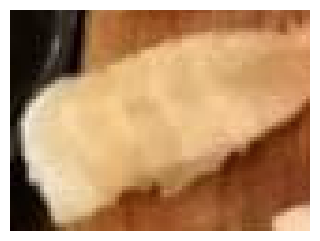

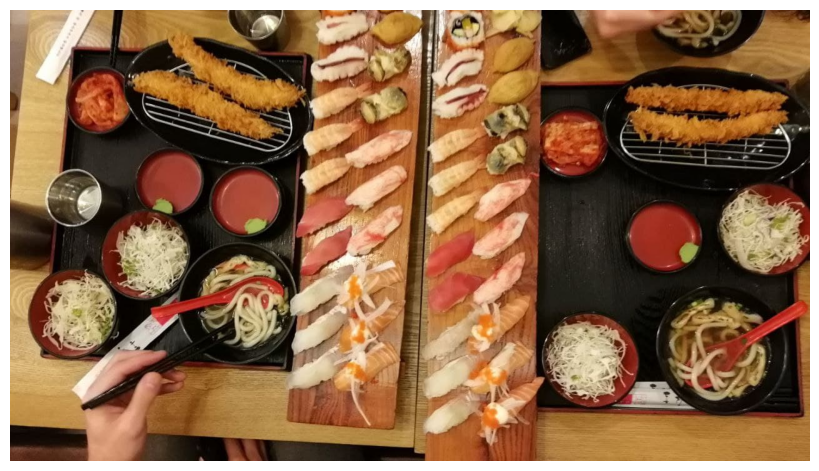

In [ ]:
susi_example = cv2.imread(str(sources_path / "susi_example.jpg"))
show_bgr(susi_example, size=(3, 4))
susi_gallery = cv2.imread(str(sources_path / "susi_gallery.jpg"))
show_bgr(susi_gallery, size=(8, 16))